# Import Libraries

In [265]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Import Data / Data Preparation

## Finding Bias in Age

In [266]:
# Import datasets

df = pd.read_csv('GiveMeSomeCredit-training.csv', index_col=0)

In [267]:
# Change RevolvingUtilizationofUnsecuredLines to percent 2 decimal places

df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'] * 100
df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].round(2)


In [268]:
# Map age to a label

def age_map(age):
  if age < 25:
    return 0
  elif 25 <= age < 35:
    return 1
  elif 35 <= age < 45:
    return 2
  elif 45 <= age < 55:
    return 3
  elif 55 <= age < 65:
    return 4
  elif 65 <= age < 75:
    return 5
  else:
    return 6

df['age'] = df['age'].apply(age_map)


In [269]:
# Take value counts of age

df['age'].value_counts()

# Find percentage of each age group from value counts

df_age = df['age'].value_counts() / len(df) * 100

Possible evidence of:
  * Sampling bias of age - Individuals between the ages of 18-25 represent around 1.38% of the training and test sets.  


In [270]:
# Count Serious Deliquents by age

df_delinq = df.groupby('age')['SeriousDlqin2yrs'].sum()

# Concate df_delinq with counts of age
df_delinq = pd.concat([df_delinq, df.groupby('age')['SeriousDlqin2yrs'].count()], axis=1)

# Rename columns
df_delinq.columns = ['delinq_yes', 'count']
df_delinq

,delinq_yes,count
age,,
0,217,2075
1,1933,17165
2,2585,28563
3,2850,36776
4,1659,34228
5,553,19823
6,229,11370


In [271]:
# Calculate percent of delinq_yes and count

df_delinq['delinq_percent'] = df_delinq['delinq_yes'] / df_delinq['count'] * 100
df_delinq

,delinq_yes,count,delinq_percent
age,,,
0,217,2075,10.457831
1,1933,17165,11.261288
2,2585,28563,9.050170
3,2850,36776,7.749619
4,1659,34228,4.846909
5,553,19823,2.789689
6,229,11370,2.014072


Possible evidence of:
  * Historical bias of age - younger age groups generally are seen as more likely to be serious delinquents than middle-aged  or elderly people based on the fact the proportion of 18-24 and 25-34 people who are serious delinquients is twice that of people 55-64 and 4x more than 65-74.

In [272]:
# Eliminate outlier Unsecured Lines values from dataset

df = df[df['RevolvingUtilizationOfUnsecuredLines'] < 1000]

# Eliminate DebtRatio from dataset

df = df.drop('DebtRatio', axis=1)

In [273]:
# Count nulls in df

df.isnull().sum()

,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
MonthlyIncome,29663
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0
NumberOfDependents,3911


In [274]:
# Delete nulls

df = df.dropna(subset=['MonthlyIncome', 'NumberOfDependents'])

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120096 entries, 1 to 150000
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      120096 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  120096 non-null  float64
 2   age                                   120096 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  120096 non-null  int64  
 4   MonthlyIncome                         120096 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       120096 non-null  int64  
 6   NumberOfTimes90DaysLate               120096 non-null  int64  
 7   NumberRealEstateLoansOrLines          120096 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  120096 non-null  int64  
 9   NumberOfDependents                    120096 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 10.1 MB


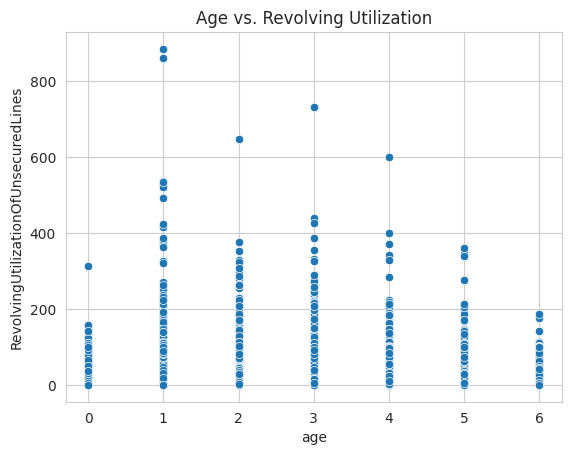

In [276]:
# Create subplots of Age with other variables

plt.title('Age vs. Revolving Utilization')
sns.set_style('whitegrid')
sns.scatterplot(x='age', y='RevolvingUtilizationOfUnsecuredLines', data=df)
plt.show()

In [277]:
# Create X and y

X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [278]:
# Split train/test data for df

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [279]:
# Scale data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [280]:
# Perform logistic regression

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train_sc, y_train)
predictions = logmodel.predict(X_test_sc)


In [281]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     33500
           1       0.55      0.05      0.10      2529

    accuracy                           0.93     36029
   macro avg       0.74      0.52      0.53     36029
weighted avg       0.91      0.93      0.90     36029



In [282]:
# Compare SeriousDlqin2yrs with predictions results

df_results = pd.DataFrame(y_test)
df_results['predictions'] = predictions
df_results

,SeriousDlqin2yrs,predictions
144639,0,0
72643,0,0
49248,0,0
26229,1,0
106191,0,0
...,...,...
47794,0,0
113056,0,0
6415,0,0
73033,0,0


In [283]:
# See the age counts of Serious delinquents and predictions

df_results.groupby('SeriousDlqin2yrs')['predictions'].value_counts()

SeriousDlqin2yrs  predictions
0                 0              33390
                  1                110
1                 0               2397
                  1                132
Name: count, dtype: int64

There are 2448 entries where the model does not believe the individual taking out the loan is likely to commit serious delinquincy within two years.  Since there are only 73 instances where the model cites the opposite, there could be some confirmation bias.

In [284]:
# Concate x_test with y_test with predictions

df_test = pd.concat([X_test, y_test], axis=1)
df_test['predictions'] = predictions
df_test


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,predictions
144639,17.27,4,0,8188.0,22,0,3,0,0.0,0,0
72643,34.23,4,0,4534.0,12,0,2,0,4.0,0,0
49248,35.96,0,0,2968.0,2,0,0,0,0.0,0,0
26229,68.85,1,0,5500.0,5,0,0,1,3.0,1,0
106191,28.89,5,0,7400.0,8,0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
47794,21.33,2,0,27500.0,14,0,2,0,2.0,0,0
113056,0.72,5,0,7721.0,9,0,0,0,0.0,0,0
6415,33.35,4,0,13518.0,6,0,2,0,0.0,0,0
73033,16.01,1,0,0.0,11,0,0,0,2.0,0,0


In [285]:
# Eliminate counts where predictions = 0

df_test = df_test[df_test['predictions'] == 1]
df_test


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,predictions
87562,92.13,2,5,2250.0,7,0,2,0,0.0,1,1
48671,88.21,3,8,9634.0,15,0,10,0,1.0,0,1
21125,111.30,1,4,5900.0,3,2,0,0,0.0,1,1
81224,146.99,1,0,6522.0,4,4,0,0,2.0,1,1
75641,142.63,2,1,2800.0,5,1,1,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
34095,168.02,1,2,1706.0,5,2,1,1,4.0,1,1
127720,198.47,2,1,6083.0,2,1,0,1,4.0,1,1
140689,92.44,4,1,3710.0,4,6,1,0,5.0,1,1
127160,46.93,4,9,5301.0,16,4,2,1,3.0,0,1


In [286]:
# Group by age and take counts of predictions

df_pred_1 = df_test.groupby('age')['predictions'].value_counts()
df_pred_1 = df_pred_1.reset_index()
df_pred_1 = df_pred_1.rename(columns={'predictions': 'pred_counts'})
df_pred_1 = pd.merge(df_pred_1, df_delinq[['delinq_yes']], on='age', how='left')
df_pred_1['pred_percent'] = df_pred_1['delinq_yes'] / df_pred_1['count']

df_pred_1

,age,pred_counts,count,delinq_yes,pred_percent
0,0,1,10,217,21.700000
1,1,1,64,1933,30.203125
2,2,1,73,2585,35.410959
3,3,1,54,2850,52.777778
4,4,1,33,1659,50.272727
5,5,1,7,553,79.000000
6,6,1,1,229,229.000000


It is clear to see the model exhibits a confirmation bias when it comes to predicting delinquints, as the model appears more lenient towards judging if an individual taking out a loan will pay it back in two years.  A historical bias also exists since 211 individuals between 18-24 of delinquincy labeling by human decision makers when in the model's views it's 11.  This age represents the lowest ratio of unfair delinquincy accustations compared to other age groups, but it is still quite high for the model's findings.

In [287]:
df['RevolvingUtilizationOfUnsecuredLines'].describe()

,RevolvingUtilizationOfUnsecuredLines
count,120096.000000
mean,33.361632
std,36.395068
min,0.000000
25%,3.500000
50%,17.660000
75%,57.670000
max,885.190000


# Unsecured Lines Bias Analysis

In [288]:
df['RevolvingUtilizationOfUnsecuredLines'].describe()

,RevolvingUtilizationOfUnsecuredLines
count,120096.000000
mean,33.361632
std,36.395068
min,0.000000
25%,3.500000
50%,17.660000
75%,57.670000
max,885.190000


In [289]:
# Group by age and describe each RevolvingUtilizationOfUnsecuredLines

df_util = df.groupby('age')['RevolvingUtilizationOfUnsecuredLines'].describe()
df_util


,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
0,1626.0,53.042466,42.944709,0.0,6.67,50.780,100.0000,312.62
1,14813.0,47.525688,42.236455,0.0,8.73,39.020,88.8100,885.19
2,24431.0,40.053469,37.680539,0.0,6.22,27.910,71.8150,647.88
3,30499.0,35.085552,35.643040,0.0,4.89,21.610,60.0650,730.90
4,26556.0,28.452622,32.940660,0.0,3.02,13.565,45.3500,600.00
5,14530.0,20.953291,29.012724,0.0,1.90,6.970,28.2225,360.36
6,7641.0,14.094201,24.754944,0.0,1.00,3.280,12.7700,186.71


In [290]:
# Map revolving credits to a label

def util_map(util):
  if util < 10:
    return 0
  elif 10 <= util < 20:
    return 1
  elif 20 <= util < 30:
    return 2
  elif 30 <= util < 40:
    return 3
  elif 40 <= util < 50:
    return 4
  elif 50 <= util < 60:
    return 5
  elif 60 <= util < 70:
    return 6
  elif 70 <= util < 80:
    return 7
  elif 80 <= util < 90:
    return 8
  else:
    return 9

df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].apply(util_map)


In [291]:
# Create X and y

X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [292]:
# Split train/test data for df

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [293]:
# Perform logistic regression

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train_sc, y_train)
predictions = logmodel.predict(X_test_sc)

In [294]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     33500
           1       0.55      0.05      0.10      2529

    accuracy                           0.93     36029
   macro avg       0.74      0.52      0.53     36029
weighted avg       0.91      0.93      0.90     36029



In [295]:
# Compare SeriousDlqin2yrs with predictions results

df_results = pd.DataFrame(y_test)
df_results['predictions'] = predictions
df_results

,SeriousDlqin2yrs,predictions
144639,0,0
72643,0,0
49248,0,0
26229,1,0
106191,0,0
...,...,...
47794,0,0
113056,0,0
6415,0,0
73033,0,0


In [296]:
# Concate x_test with y_test with predictions

df_test = pd.concat([X_test, y_test], axis=1)
df_test['predictions'] = predictions
df_test

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,predictions
144639,1,4,0,8188.0,22,0,3,0,0.0,0,0
72643,3,4,0,4534.0,12,0,2,0,4.0,0,0
49248,3,0,0,2968.0,2,0,0,0,0.0,0,0
26229,6,1,0,5500.0,5,0,0,1,3.0,1,0
106191,2,5,0,7400.0,8,0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
47794,2,2,0,27500.0,14,0,2,0,2.0,0,0
113056,0,5,0,7721.0,9,0,0,0,0.0,0,0
6415,3,4,0,13518.0,6,0,2,0,0.0,0,0
73033,1,1,0,0.0,11,0,0,0,2.0,0,0


In [297]:
# Eliminate counts where predictions = 0

df_test = df_test[df_test['predictions'] == 1]
df_test

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,predictions
87562,9,2,5,2250.0,7,0,2,0,0.0,1,1
48671,8,3,8,9634.0,15,0,10,0,1.0,0,1
21125,9,1,4,5900.0,3,2,0,0,0.0,1,1
81224,9,1,0,6522.0,4,4,0,0,2.0,1,1
75641,9,2,1,2800.0,5,1,1,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
34095,9,1,2,1706.0,5,2,1,1,4.0,1,1
127720,9,2,1,6083.0,2,1,0,1,4.0,1,1
140689,9,4,1,3710.0,4,6,1,0,5.0,1,1
127160,4,4,9,5301.0,16,4,2,1,3.0,0,1


In [298]:
# Count Serious Deliquents by age

df_delinq = df.groupby('RevolvingUtilizationOfUnsecuredLines')['SeriousDlqin2yrs'].sum()

# Concate df_delinq with counts of age
df_delinq = pd.concat([df_delinq, df.groupby('RevolvingUtilizationOfUnsecuredLines')['SeriousDlqin2yrs'].count()], axis=1)

# Rename columns
df_delinq.columns = ['delinq_yes', 'count']
df_delinq

,delinq_yes,count
RevolvingUtilizationOfUnsecuredLines,,
0,975,48512
1,431,14237
2,362,9435
3,394,7456
4,403,6254
5,477,5294
6,476,4621
7,576,4236
8,676,4385


In [299]:
# Group by Revolving Credit and take counts of predictions

df_pred_2 = df_test.groupby('RevolvingUtilizationOfUnsecuredLines')['predictions'].value_counts()
df_pred_2 = df_pred_2.reset_index()
df_pred_2 = df_pred_2.rename(columns={'predictions': 'pred_counts'})
df_pred_2 = pd.merge(df_pred_2, df_delinq[['delinq_yes']], on='RevolvingUtilizationOfUnsecuredLines', how='left')
df_pred_2['pred_percent'] = df_pred_2['delinq_yes'] / df_pred_2['count']

df_pred_2



,RevolvingUtilizationOfUnsecuredLines,pred_counts,count,delinq_yes,pred_percent
0,0,1,1,975,975.000000
1,4,1,2,403,201.500000
2,5,1,5,477,95.400000
3,6,1,1,476,476.000000
4,7,1,1,576,576.000000
5,8,1,16,676,42.250000
6,9,1,216,3572,16.537037
